# JAXing things away

## 1. Automatic differentiation

### Demo with an algebraic function
Let us see how to calculate the partial derivatives of any function with jax. Consider the function:

$$
f=\frac{ \tanh ^{-1}(x)}{1-e^{-x}} e^{-x}
$$

its derivative is:
$$
f'(x) = \frac{\left[\tanh^{-1}(x)\left(1-x^{2}\right)-1\right] e^{x} +1}{\left(e^{x}-1\right)^{2}\left(x^{2}-1\right)}
$$

Let us implement both and compare with the autodiff result.

In [1]:
# import the numpy API from jax, and the gradient function.
from jax import numpy as jnp, grad

In [2]:
# the function above
def f(x):
    return jnp.arctanh(x) * jnp.exp(-x) / (1 - jnp.exp(-x))

# its analytical derivative!
def d_f(x):
    num = (jnp.arctanh(x) * (1 - x**2) - 1) * jnp.exp(x) + 1
    den = (jnp.exp(x) - 1)**2 * (x**2 - 1)
    return num / den

# its automatic derivative.
d_f_auto = grad(f)

In [3]:
# comparing derivatives!
x = -0.3
print(f"Derivative at x = {x:.03f}:")
print(f"Symbolic:  {d_f(x):.05f}")
print(f"Automatic: {d_f_auto(x):.05f}")

Derivative at x = -0.300:
Symbolic:  -0.82646
Automatic: -0.82646


## 2. Just-in-time compilation

The philosophy of JAX is writing simple, atomic functions and composing them, then just-in-time compile the top function for optimal performance. Let us see how it works.

In [4]:
# import the just in time compiler 
from jax import jit
from time import time

# a useless function doing some idiotic stuff:
def some_function():
    x = 2*jnp.ones(10)
    for _ in range(20):
        x = x**0.5
    return x

# first run it without compiling:
t0 = time()
some_function()
print(f"Execution time without jit: {1000*(time()-t0):.02f} ms")

# now let's jit it.
jitted = jit(some_function)
# run it a first time ...
t0 = time()
jitted()
print(f"Execution time including compiling: {1000*(time()-t0):.02f} ms")

# and again
t0 = time()
jitted()
print(f"Execution time after compiling: {1000*(time()-t0):.02f} ms")

Execution time without jit: 42.10 ms
Execution time including compiling: 23.59 ms
Execution time after compiling: 0.05 ms


In [5]:
# Note: the construct you will see most of the time is the use of jit as a decorator:
@jit
def my_function():
    pass
# is strictly equivalent to
def my_function():
    pass
my_function = jit(my_function)

**What makes jit so fast?**
- The function is converted to XLA (accelerated linear algebra), then the XLA compiler does most of the magic.
- In the present case, it might unroll the `for` loop: it identifies that the loop just does repeated operations without external dependencies.
- In the present case still, it might even identify what we should have noticed when writing the code: repeated exponentiation is just exponentiating once with the sum of the exponents.
- **And the best part:** XLA understands your hardware, whether it is a CPU, GPU, or other accelerator, it knows exactly how to cache things in an optimal way, eliminating overheads at every level!

## 3. Batching
We wrote a for loop in the previous example. Do not ever do this again when writing in JAX. In particular, looping over arrays is extremely unefficient, yet the compiler might still try and unroll such loops, resulting in compile times possibly longer than the age of the Universe. 

Instead, use batching, which the JAX API makes incredibly easy to do!

In [6]:
import numpy as np  # to generate some fake data
np.random.seed(0)
import matplotlib.pyplot as plt

from jax import vmap  # vectorized map! how to do complex operations on a vector of length N in O(1) time.

Say we are fitting a polynomial on some data, which comes in as arrays of length 100:

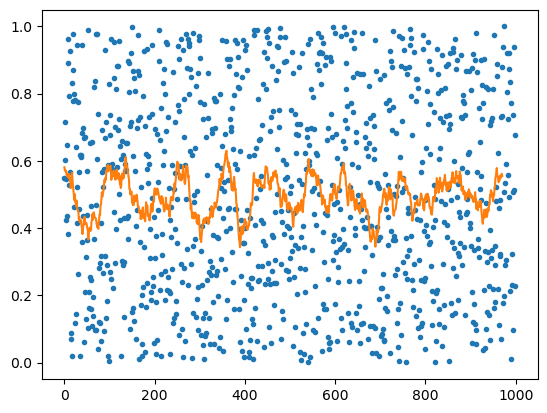

In [7]:
y = np.random.uniform(size=1000)
# just take a moving average of the data ...
def moving_average(data, window_size=30):
    cumsum = jnp.cumsum(data)
    cumsum = jnp.insert(cumsum, 0, 0)
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size

plt.figure()
plt.plot(y, '.')
plt.plot(moving_average(y))

Now, say we have a bunch of data coming in:

In [8]:
# 20 times the 'data' of the above plot
ys = jnp.array([np.random.uniform(size=1000) for _ in range(20)])

Start with the wrong way of doing things

In [9]:
@jit
def fit_all_data_loop(ys):
    smoothed = []
    for y in ys:
        smoothed.append(moving_average(y))
    return smoothed

t0 = time()
fit_all_data_loop(ys)
print(f"Execution time including compiling: {1000*(time()-t0):.02f} ms")

t0 = time()
fit_all_data_loop(ys)
print(f"Execution time after compiling: {1000*(time()-t0):.02f} ms")

Execution time including compiling: 4087.64 ms
Execution time after compiling: 0.45 ms


Like ...3-5 seconds of compilation time? It can get a lot worse, try increasing the number of observations to 1000 if you feel like having to kill the notebook completely to recover.

And now the right way

In [10]:
@jit
def fit_all_data(ys):
    batched = vmap(moving_average, in_axes=(0,))
    return batched(ys)

t0 = time()
fit_all_data(ys)
print(f"Execution time including compiling: {1000*(time()-t0):.02f} ms")

t0 = time()
fit_all_data(ys)
print(f"Execution time after compiling: {1000*(time()-t0):.02f} ms")

Execution time including compiling: 349.29 ms
Execution time after compiling: 0.47 ms


## 4. Putting it together in a toy example

The most widespread usage of automatic differentiation are optimization problems. Let us create a very stupid problem, where we want to recover the "true signal" $t$ hidden in a noisy / blurred observation $o$.

$$
o = k * t + n
$$

This is the classic ill-posed problem of deconvolution. JAX doesn't magically solve it, but it does give us more direct ways to tackle it.

We start by generating some fake data:

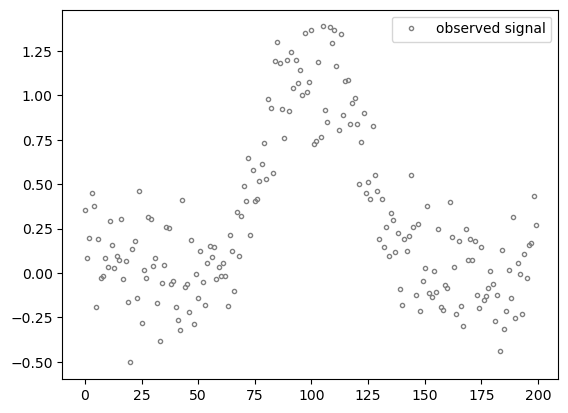

In [22]:
# this is our true signal
truth = np.load('true_signal.npy')
# and the "instrument response", just something to blur the true signal with.
kernel = np.load('kernel.npy')
# our observation, blur with the kernel and add noise.
np.random.seed(0)
obs = np.convolve(truth, kernel, mode='same') + np.random.normal(scale=0.2, size=truth.size)
# check it out
plt.figure()
plt.plot(obs, '.', label='observed signal', mfc='None', color='gray')
#plt.plot(truth, color='mediumblue', ls='--', label='true signal')
plt.legend()

So, our true signal is bimodal, but our observations are blurry and noisy: hiding the nature of the true signal. Luckily, in this example we know exactly what the instrumental blurring is! We can therefore forward model the data points with **very** minimal assumptions. While traditional methods would require modelling with very coercive functional forms, `JAX` allows us to optimize a single parameter per data point, and add a condition of smoothness to our model. This condition of smoothness is the very minimal assumption we are making.

#### The Plan
- Define a model, that is a function, `compute_model`, that transforms our *estimated* true signal to what we expect to observe.
- Define a way to enforce smoothness, we'll request the total variation of the signal to be decently small: function `regularization`.
- Define a data fidelity term, requiring that our model is similar to the input data, in `chi2`.
- Combine all this in the `cost` function, of which we'll immediately calculate the gradient! The gradient will guide any optimizer that can use it to a local minimum, very fast.

In [23]:
# a simple model ...our estimated true model is blurred by the response to yield the observed signal.
def compute_model(params):
    # Here the model is very simple, just bluring our estimated signal with the instrumental response. 
    # The point, however, is that this can become arbitrarily complex, modelling physics, instrumental effects, anything. 
    model = jnp.convolve(params, kernel, mode='same')
    return model

# an easy prior on what the reconstruction should look like is something smooth. 
def regularization(array):
    # Again, this can also be a lot more complex. We could even encode priors on what our solution should look like in neural networks.
    # JAX would calculate the gradient across a huge neural network all the same.
    return jnp.sum(jnp.diff(array)**2)

# the data fidelity term ...our reconstructed model should match the observation
def chi2(params, obs):
    model = compute_model(params)
    return jnp.sum( (model - obs)**2 )  # assuming uniform, unit variance for this example.

# and the metric we will minimize, a mixture of recreating the observed data while being smooth enough.
def cost(params, obs):
    return chi2(params, obs) + regularization(params)

# get the partial derivatives of this relatively long sequence of operations for free!
cost_grad = jit(grad(cost, argnums=0))

Now we can just come up with an initial guess of what the true signal might look like ...or just start from zeros everywhere. Then we optimize them as to minimize our cost function with any minimization algorithm that can take advantage of the gradient.

(Try one that doesn't by replacing the minimize statement with this!)
```
res = minimize(cost, method='Nelder-Mead', x0=params_ini, args=(obs,))
```

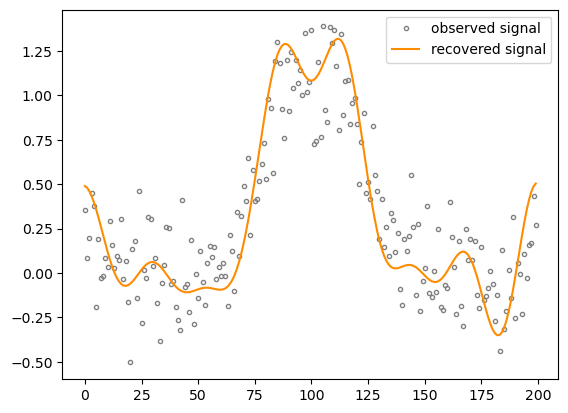

In [24]:
from scipy.optimize import minimize

params_ini = jnp.zeros_like(obs)
# just use some algorithm that uses the gradient to find optimal parameters.
res = minimize(cost, jac=cost_grad, method='CG', x0=params_ini, args=(obs,))

plt.figure()
plt.plot(obs, '.', label='observed signal', mfc='None', color='gray')
#plt.plot(truth, color='mediumblue', ls='--', label='true signal')
plt.plot(res.x, label='recovered signal', color='darkorange')
plt.legend()

We recover some information! At least, we get a hint that our true data might be multimodal. How can we be sure? What about throwing more data at it? After all, astronomical data rarely come alone. So, how do we combine the information of multiple observations?

First let's make some independent observations.

Text(0.5, 1.0, 'Average of multiple observations')

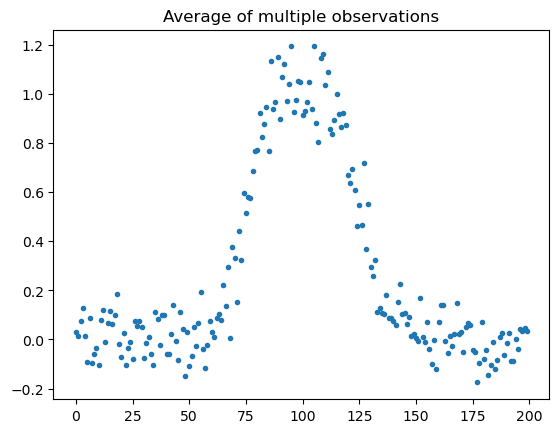

In [26]:
# make some independent observations
np.random.seed(0)
obs = jnp.array([np.convolve(truth, kernel, mode='same') + np.random.normal(scale=0.2, size=truth.size) for _ in range(5)])

# can we see multimodality with an average?
plt.figure()
plt.plot(np.mean(obs, axis=0), '.')
plt.title('Average of multiple observations')

Averaging doesn't exactly help.

Let's instead forward model with `JAX` again.

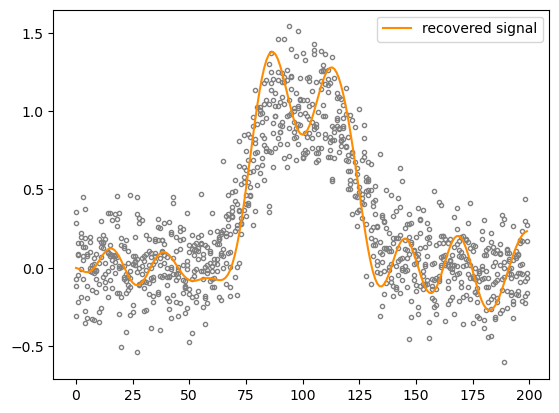

In [28]:
# batch the cost function so it handles multiple inputs at once
chi2_vmap = jit(vmap(chi2, in_axes=(None, 0)))
# in_axes=(None, 0) means: do not batch on the first argument, and batch on the first axis of the second argument.

# we also need to modify our cost function. Just taking the mean of the data fidelity term here.
def cost(params, obs):
    return jnp.mean(chi2_vmap(params, obs)) + 0.1 * regularization(params)


# gradient of an even longer list of operations now! still free
cost_grad = jit(grad(cost, argnums=0))

# fit our model to all this data at once.
res = minimize(cost, jac=cost_grad, method='CG', x0=params_ini, args=(obs,))

plt.figure()
for ob in obs:
    plt.plot(ob, '.', mfc='None', color='gray')
#plt.plot(truth, color='mediumblue', ls='--', label='true signal')
plt.plot(res.x, label='recovered signal', color='darkorange')

plt.legend()